In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq

## Exercise 1: Upgrade Assignment 2 code to train & test k-layer networks

In [2]:
def Normalization(X):
    mean_X = X.mean(axis=0)
    std_X = X.std(axis=0)
    return (X - mean_X) / std_X

In [3]:
def LoadBatch(filename):
    with open('Dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

        X = (dict[b"data"] / 255).T
        y = dict[b"labels"]
        Y = (np.eye(10)[y]).T

    return X, Y, y

In [4]:
def initialization(input_dimension, hidden_dimensions, output_dimension, seed=233): 
    
    # k layers for the net
    k = len(hidden_dimensions)+1
    
    # Create each lists
    W, b, gamma, beta = [None]*k, [None]*k, [None]*(k-1), [None]*(k-1)
    net_dimensions = [input_dimension]+hidden_dimensions+[output_dimension]
    
    # Initialization
    np.random.seed(seed)
    for layer in range(k):
        
        # Define dimensions of the layer
        inputs = net_dimensions[layer]
        outputs = net_dimensions[layer+1]
        
        scale = np.sqrt(2/inputs)
        
        # Initialize weights, bias, gammas and betas
        W[layer] = np.random.normal(size=(outputs, inputs), loc=0, scale=scale)
        b[layer] = np.zeros((outputs, 1))
        if layer<(k-1):
            gamma[layer] = np.ones((outputs, 1))
            beta[layer] = np.zeros((outputs, 1))
        
    return W, b, gamma, beta

In [5]:
X,Y,y = LoadBatch('data_batch_1')
X = Normalization(X)
W, b, gamma, beta = initialization(X.shape[0], [50,100], Y.shape[0])
Xtest, Ytest, ytest = LoadBatch('test_batch')
Xtest = Normalization(Xtest)

In [8]:
len(W), len(b), len(gamma), len(beta)

(3, 3, 2, 2)

In [9]:
W[0].shape, b[0].shape, gamma[0].shape, beta[0].shape

((50, 3072), (50, 1), (50, 1), (50, 1))

In [10]:
W[1].shape, b[1].shape, gamma[1].shape, beta[1].shape

((100, 50), (100, 1), (100, 1), (100, 1))

In [11]:
W[2].shape, b[2].shape

((10, 100), (10, 1))

## Exercise 2: Can I train multi-layer networks?

In [5]:
def ReLu(S):
    H = S
    H[H<0] = 0
    return H

def softmax(S):
    E = np.exp(S)
    P = E/E.sum(axis=0)
    return P

In [6]:
def EvaluateClassifier_refer(X, W, b, gamma, beta, mean=None, var=None, batch_normalization=False):
    
    k = len(W)
    X_layers, S, S_BN = [X.copy()]+[None]*(k-1), [None]*(k-1), [None]*(k-1)
    if batch_normalization:
        if mean is None and var is None:
            return_mean_var = True
            mean, var = [None]*(k-1), [None]*(k-1)
        else:
            return_mean_var = False
    
    for l in range(k-1):
        S[l] = W[l]@X_layers[l]+b[l]
        if batch_normalization:
            if return_mean_var:
                mean[l] = S[l].mean(axis=1).reshape(-1,1)
                var[l] = S[l].var(axis=1).reshape(-1,1)
            S_BN[l] = (S[l]-mean[l])/(np.sqrt(var[l]+1e-15))
            S_BatchNorm_Scaled = S_BN[l]*gamma[l]+beta[l]
            X_layers[l+1] = ReLu(S_BatchNorm_Scaled)
        else:
            X_layers[l+1] = ReLu(S[l])
        
    P = softmax(W[k-1]@X_layers[k-1]+b[k-1])
    
    if batch_normalization:
        if return_mean_var:
            return P, S_BN, S, X_layers[1:], mean, var
        else:
            return P, S_BN, S, X_layers[1:]
    else:
        return P, X_layers[1:]

In [7]:
def EvaluateClassifier(X, W, b, mean=None, var=None):
    k = len(W)
    layers_input = [None]*(k)
    layers_input[0] = X
    S = [None]*(k)
        
    for l in range(k-1):
        S[l] = W[l]@layers_input[l]+b[l]
        layers_input[l+1] = ReLu(S[l])
        
    P = softmax(W[k-1]@layers_input[k-1]+b[k-1])
    
    return P, layers_input[1:]

In [8]:
def EvaluateClassifier_BN(X, W, b, gamma, beta, mean=None, var=None):
    k = len(W)
    layers_input = [None]*(k)
    layers_input[0] = X
    S, S_BN = [None]*(k), [None]*(k)
    compute_mean_var = False
    if mean is None and var is None:
        compute_mean_var = True
        mean, var = [None]*(k-1), [None]*(k-1)
        
    for l in range(k-1):
        S[l] = W[l]@layers_input[l]+b[l]
        if compute_mean_var:
            mean[l] = S[l].mean(axis=1).reshape(-1,1)
            var[l] = S[l].var(axis=1).reshape(-1,1)
        S_BN[l] = (S[l]-mean[l])/(np.sqrt(var[l]+1e-15))
        layers_input[l+1] = ReLu(S_BN[l]*gamma[l]+beta[l])
        
    P = softmax(W[k-1]@layers_input[k-1]+b[k-1])
    
    return P, layers_input[1:], S, S_BN, mean, var

In [9]:
def ComputeCost(X, Y, lambda_, W, b):
    
    P, layers_input = EvaluateClassifier(X, W, b)
    
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    loss_regularization = 0
    for l in W:
        loss_regularization += lambda_*((l**2).sum())
        
    J = loss_cross/X.shape[1]+loss_regularization
    
    return J

In [10]:
def ComputeCost_BN(X, Y, lambda_, W, b, gamma, beta, mean=None,var=None):
    
    P, layers_input,_ ,_, _, _ = EvaluateClassifier_BN(X, W, b, gamma, beta)
    
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    loss_regularization = 0
    for l in W:
        loss_regularization += lambda_*((l**2).sum())
        
    J = loss_cross/X.shape[1]+loss_regularization
    
    return J

In [11]:
def ComputeAccuracy(X, y, W, b):
    
    # Compute the predictions
    P, layers_input = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    accuracy = np.mean(y==np.argmax(P, 0))
    
    return accuracy

In [12]:
def ComputeAccuracy_BN(X, y, W, b, gamma, beta, mean=None, var=None):
    
    P, layers_input, _, _, _, _ = EvaluateClassifier_BN(X, W, b, gamma, beta)
    
    accuracy = np.mean(y==np.argmax(P, 0))
    
    return accuracy

In [13]:
def BatchNormBackPass(G, S, mean, var):
    n = S.shape[1]
    G1 = G*(((var+1e-15)**(-0.5))@np.ones((1,n)))
    G2 = G*(((var+1e-15)**(-1.5))@np.ones((1,n)))
    D = S-mean@np.ones((1,n))
    c = (G2*D)@np.ones((n,1))
    
    return G1-(G1@np.ones((n,1)))/n-D*(c@np.ones((1,n)))/n

def ComputeGradients(X, Y, P, S_BN, S, X_layers, W, b, gamma, beta, mean,var,lambda_,batch_normalization):

    k = len(W)
    grad_W, grad_b = [None]*k, [None]*k
    if batch_normalization:
        grad_gamma, grad_beta = [None]*(k-1), [None]*(k-1)

    n = X.shape[1]
    X_layers = [X.copy()]+X_layers
    G = P-Y
    grad_W[k-1] = (G@X_layers[k-1].T)/n+2*lambda_*W[k-1]
    grad_b[k-1] = (G@np.ones((n,1)))/n
    
    G = W[k-1].T@G
    G = G*(X_layers[k-1]>0)
    
    for l in range(k-2, -1, -1):
        if batch_normalization:
            
            grad_gamma[l] = ((G*S_BN[l])@np.ones((n,1)))/n
            grad_beta[l] = (G@np.ones((n,1)))/n

            G = G*(gamma[l]@np.ones((1,n)))

            G = BatchNormBackPass(G, S[l], mean[l], var[l])
        
        grad_W[l] = (G@X_layers[l].T)/n+2*lambda_*W[l]
        grad_b[l] = (G@np.ones((n,1)))/n
        
        if l>0:
            G = W[l].T@G
            G = G*(X_layers[l]>0)
        
    if batch_normalization:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

In [14]:
def ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean, var, batch_normalization, h=0.000001):
    
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if batch_normalization:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    c = ComputeCost_BN(X, Y, lambda_, W, b, gamma, beta, mean, var)
    k = len(W)
    for l in range(k):
        
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost_BN(X, Y, lambda_, W, b_try, gamma, beta, mean, var)
            grad_b[l][i,0] = (c2-c)/h
        
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost_BN(X, Y, lambda_, W_try, b, gamma, beta, mean, var)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and batch_normalization:
            
            for i in range(gamma[l].shape[0]):
                gamma_try = [gamma_l.copy() for gamma_l in gamma]
                gamma_try[l][i,0] += h
                c2 = ComputeCost_BN(X, Y, lambda_, W, b, gamma_try, beta, mean, var)
                grad_gamma[l][i,0] = (c2-c)/h
            
            for i in range(beta[l].shape[0]):
                beta_try = [beta_l.copy() for beta_l in beta]
                beta_try[l][i,0] += h
                c2 = ComputeCost_BN(X, Y, lambda_, W, b, gamma, beta_try, mean, var)
                grad_beta[l][i,0] = (c2-c)/h
    
    if batch_normalization:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

In [15]:
def test_grad(X, Y, W1, W2, b1, b2, lambda_):
    # Compute the gradients analytically
    P, H = EvaluateClassifier(X, W1[:,0:20], b1, W2, b2)
    analytically_grad = ComputeGradients(X, Y, P, H, W1[:,0:20], W2, lambda_)

    # Compute the gradients numerically
    numerically_grad = ComputeGradsNum(X, Y, W1[:,0:20], b1, W2, b2, lambda_,
                                                             h=0.000001)
    try:
        for i in range(4):
            np.testing.assert_almost_equal(analytically_grad[i], numerically_grad[i], decimal=6)
    except:
        return
    print("Gradients can work.")

In [56]:
# Take a part of data
X,Y,y = LoadBatch('data_batch_1')
X = X[0:20,0:5]
Y = Y[:,0:5]
lambda_ = 0

In [57]:
X = Normalization(X)
W, b, gamma, beta = initialization(X.shape[0], [50], Y.shape[0])

In [58]:
# Compute the gradients numerically
grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=gamma, beta=beta, mean=None, var=None,
                                         batch_normalization=True)

In [59]:
# Compute the gradients analytically
P, X_layers, S, S_BN, mean, var = EvaluateClassifier_BN(X, W, b, gamma, beta)
grad_W, grad_b,grad_gamma, grad_beta = ComputeGradients(X=X, Y=Y, P=P, S_BN=S_BN, S=S, X_layers=X_layers, W=W, b=b, 
                                  gamma=gamma, beta=beta, mean=mean, var=var, lambda_=lambda_,
                                  batch_normalization=True)

In [75]:
grad_gamma_num[0].shape

array([[-0.0890878 ],
       [-0.0485045 ],
       [-0.02231203],
       [-0.06807713],
       [-0.01053432],
       [ 0.05934032],
       [ 0.011443  ],
       [ 0.09455277],
       [ 0.08489298],
       [ 0.07287302],
       [ 0.08214813],
       [ 0.05140063],
       [ 0.06175088],
       [-0.06648122],
       [-0.01911067],
       [ 0.01539629],
       [ 0.02030443],
       [ 0.09813177],
       [ 0.05931045],
       [-0.11635316],
       [-0.08878747],
       [ 0.00848905],
       [ 0.02098806],
       [ 0.02328204],
       [ 0.10147399],
       [ 0.04496553],
       [ 0.02090554],
       [ 0.02687529],
       [ 0.07095236],
       [-0.02663705],
       [-0.06967422],
       [-0.01798162],
       [-0.02465951],
       [ 0.00803027],
       [ 0.04695905],
       [ 0.14042386],
       [ 0.03826834],
       [ 0.05310737],
       [ 0.12185817],
       [-0.01349419],
       [ 0.03353664],
       [-0.01330901],
       [-0.02055832],
       [ 0.09051658],
       [ 0.03253837],
       [ 0

In [76]:
np.array(grad_gamma_num[0])

array([[-0.0890878 ],
       [-0.0485045 ],
       [-0.02231203],
       [-0.06807713],
       [-0.01053432],
       [ 0.05934032],
       [ 0.011443  ],
       [ 0.09455277],
       [ 0.08489298],
       [ 0.07287302],
       [ 0.08214813],
       [ 0.05140063],
       [ 0.06175088],
       [-0.06648122],
       [-0.01911067],
       [ 0.01539629],
       [ 0.02030443],
       [ 0.09813177],
       [ 0.05931045],
       [-0.11635316],
       [-0.08878747],
       [ 0.00848905],
       [ 0.02098806],
       [ 0.02328204],
       [ 0.10147399],
       [ 0.04496553],
       [ 0.02090554],
       [ 0.02687529],
       [ 0.07095236],
       [-0.02663705],
       [-0.06967422],
       [-0.01798162],
       [-0.02465951],
       [ 0.00803027],
       [ 0.04695905],
       [ 0.14042386],
       [ 0.03826834],
       [ 0.05310737],
       [ 0.12185817],
       [-0.01349419],
       [ 0.03353664],
       [-0.01330901],
       [-0.02055832],
       [ 0.09051658],
       [ 0.03253837],
       [ 0

In [77]:
np.testing.assert_almost_equal(np.array(grad_gamma_num[0]), np.array(grad_gamma[0]), decimal=5)

In [14]:
# Check the gradients.
test_grad(X, Y, W1, W2, b1, b2, lambda_)

Gradients can work.


## Exercise 3: Implement batch normalization

In [16]:
def Separate_mini_batch(Xtrain,Ytrain, n_batch):
    Xbatches = []
    Ybatches = []
    for j in range(1,int(Xtrain.shape[1]/n_batch)+1):
        start = (j-1)*n_batch
        end = j*n_batch
        Xbatch = Xtrain[:,start:end]
        Ybatch = Ytrain[:,start:end]
        Xbatches.append(Xbatch)
        Ybatches.append(Ybatch)
    return Xbatches,Ybatches

In [30]:
def train_network(X, Y, y, parameters, lambda_, W, b, gamma=None, beta=None, X_val=None, Y_val=None,
                  y_val=None, batch_normalization=False, alpha=0.9, report_process=True):
    n = X.shape[1]
    eta_min = parameters['eta_min']
    eta_max = parameters['eta_max']
    eta_range = eta_max - eta_min
    step_size = parameters['step_size']
    n_batch = parameters['n_batch']
    cycles = parameters['cycles']

    if batch_normalization:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]

    if batch_normalization:
        training_result = {'updates': [-1],
                   'loss_train': [ComputeCost_BN(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None)],
                   'acc_train': [ComputeAccuracy_BN(X, y, W, b, gamma, beta, mean=None, var=None)]}
        if X_val is not None:
            training_result['loss_val'] = [ComputeCost_BN(X_val, Y_val, lambda_, W, b, gamma, beta, mean=None, var=None)]
            training_result['acc_val'] = [ComputeAccuracy_BN(X_val, y_val, W, b, gamma, beta, mean=None, var=None)]

    else:
        training_result = {'updates': [-1],
                   'loss_train': [ComputeCost(X, Y, lambda_, W, b)],
                   'acc_train': [ComputeAccuracy(X, y, W, b)]}
        if X_val is not None:
            training_result['loss_val'] = [ComputeCost(X_val, Y_val, lambda_, W, b)]
            training_result['acc_val'] = [ComputeAccuracy(X_val, y_val, W, b)]

    X_original, Y_original, y_original = X.copy(), Y.copy(), y.copy()

    data_batches = {}
    max_batch_index = n // n_batch - 1
    for j in range(max_batch_index + 1):
        j_start = j * n_batch
        j_end = (j + 1) * n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:, inds], Y[:, inds], [y[index] for index in inds])

    batch_index = 0
    for cycle in range(cycles):
        for t in range(2 * cycle * step_size, 2 * (cycle + 1) * step_size):

            if t >= 2 * cycle * step_size and t < (2 * cycle + 1) * step_size:
                eta = eta_min + (t - 2 * cycle * step_size) / step_size * eta_range
            elif t >= (2 * cycle + 1) * step_size and t < 2 * (cycle + 1) * step_size:
                eta = eta_max - (t - (2 * cycle + 1) * step_size) / step_size * eta_range

            X_batch, Y_batch, y_batch = data_batches[batch_index]
            if batch_normalization:
                P, X_layers, S, S_BN, mean, var = EvaluateClassifier_BN(X_batch, W, b, gamma, beta)
            else:
                P, X_layers = EvaluateClassifier(X_batch, W, b)

            if cycle == 0 and t == 0 and batch_normalization:
                mean_avg = mean
                var_avg = var
            elif batch_normalization:
                mean_avg = [alpha * mean_avg[l] + (1 - alpha) * mean[l] for l in range(len(mean))]
                var_avg = [alpha * var_avg[l] + (1 - alpha) * var[l] for l in range(len(var))]
            else:
                mean_avg = None
                var_avg = None

            if batch_normalization:
                grad_W, grad_b, grad_gamma, grad_beta = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN, S, X_layers, W, b, gamma, beta, mean, var,
                                     lambda_, batch_normalization=True)
            else:
                grad_W, grad_b = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b,
                                     gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                     batch_normalization=False)

            W = [W[l] - eta * grad_W[l] for l in range(len(W))]
            b = [b[l] - eta * grad_b[l] for l in range(len(b))]
            if batch_normalization:
                gamma = [gamma[l] - eta * grad_gamma[l] for l in range(len(gamma))]
                beta = [beta[l] - eta * grad_beta[l] for l in range(len(beta))]
            batch_index += 1
            if batch_index > max_batch_index:
                batch_index = 0

                if batch_normalization:
                    training_result['updates'].append(t + 1)
                    training_result['acc_train'].append(ComputeAccuracy_BN(X, y, W, b, gamma, beta, mean_avg, var_avg))
                    training_result['loss_train'].append(ComputeCost_BN(X, Y, lambda_, W, b, gamma, beta, mean_avg, var_avg))
                    if X_val is not None:
                        training_result['acc_val'].append(
                            ComputeAccuracy_BN(X_val, y_val, W, b, gamma, beta, mean_avg, var_avg))
                        training_result['loss_val'].append(
                            ComputeCost_BN(X_val, Y_val, lambda_, W, b, gamma, beta, mean_avg, var_avg))

                else:
                    training_result['updates'].append(t + 1)
                    training_result['acc_train'].append(ComputeAccuracy(X, y, W, b))
                    training_result['loss_train'].append(ComputeCost(X, Y, lambda_, W, b))
                    if X_val is not None:
                        training_result['acc_val'].append(ComputeAccuracy(X_val, y_val, W, b))
                        training_result['loss_val'].append(ComputeCost(X_val, Y_val, lambda_, W, b))

                if report_process == True:
                    info = "In update " + str(t + 1) + '/' + str(2 * cycles * step_size) + " finishes epoch " + \
                           str(len(training_result['updates']) - 1) + ": loss=" + str(training_result['loss_train'][-1]) + \
                           " and accuracy=" + str(training_result['acc_train'][-1]) + " (training set) \r"
                    print(info)

                np.random.seed(t)
                permuted_indexes = np.random.permutation(n)
                X = X_original[:, permuted_indexes]
                Y = Y_original[:, permuted_indexes]
                y = [y_original[index] for index in permuted_indexes]

                data_batches = {}
                for j in range(max_batch_index + 1):
                    j_start = j * n_batch
                    j_end = (j + 1) * n_batch
                    inds = range(j_start, j_end)
                    data_batches[j] = (X[:, inds], Y[:, inds], [y[index] for index in inds])

    if batch_normalization:
        return W, b, gamma, beta, mean_avg, var_avg, training_result
    else:
        return W, b, training_result

In [18]:
def plot_training_performance(training_result, save_path = None):
    _, plots = plt.subplots(1, 2, figsize=(15, 5))
    for plot_type, ax in zip(['loss', 'acc'], plots.flatten()):
        best_epoch_train = np.argmin(training_result[plot_type + '_train']) if plot_type == 'loss' else np.argmax(
            training_result[plot_type + '_train'])
        optimal_value_train = np.round(training_result[plot_type + '_train'][best_epoch_train], 5)

        label = 'Training: ' + 'optimization is ' + str(optimal_value_train) + ' when update ' + str(
            training_result['updates'][best_epoch_train])
        ax.plot(training_result['updates'], training_result[plot_type + '_train'], color='g', label=label)

        best_epoch_val = np.argmin(training_result[plot_type + '_val']) if plot_type == 'loss' else np.argmax(
            training_result[plot_type + '_val'])
        optimal_value_val = np.round(training_result[plot_type + '_val'][best_epoch_val], 5)

        label = 'Validation: ' + 'optimization is ' + str(optimal_value_val) + ' when update ' + str(
            training_result['updates'][best_epoch_val])
        ax.plot(training_result['updates'], training_result[plot_type + '_val'], color='r', label=label)

        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if plot_type == 'acc' else 'Loss')
        ax.legend()
        if save_path is not None:
            plt.savefig(save_path)

In [19]:
def split_dataset(X, Y, y, val_num):
    np.random.seed(10)
    val_index = np.random.choice(range(X.shape[1]), val_num, replace=False)
    X_val = Normalization(X[:,val_index])
    Y_val = Y[:,val_index]
    y_val = [y[i] for i in val_index]

    X_train = Normalization(np.delete(X, val_index, 1))
    Y_train = np.delete(Y, val_index, 1)
    y_train = [y[i] for i in range(X.shape[1]) if i not in val_index]
               
    return X_val, Y_val, y_val, X_train, Y_train, y_train

In [20]:
X1,Y1,y1 = LoadBatch('data_batch_1')
X2,Y2,y2 = LoadBatch('data_batch_2')
X3,Y3,y3 = LoadBatch('data_batch_3')
X4,Y4,y4 = LoadBatch('data_batch_4')
X5,Y5,y5 = LoadBatch('data_batch_5')
Xtest, Ytest, ytest = LoadBatch('test_batch')

X = np.hstack((X1, X2, X3, X4, X5))
Y = np.hstack((Y1, Y2, Y3, Y4, Y5))
y = np.array(y1+y2+y3+y4+y5)
X_val, Y_val, y_val, X_train, Y_train, y_train = split_dataset(X, Y, y, 5000)
Xtest = Normalization(Xtest)

### 2-layer network(without batch normalization)

In [36]:
layers_setting = [50]
W, b, gamma, beta = initialization(X.shape[0], layers_setting, Y.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, 
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=False)

In update 450/9000 finishes epoch 1: loss=2.215939089027633 and accuracy=0.4150888888888889 (training set) 
In update 900/9000 finishes epoch 2: loss=1.9398916599814144 and accuracy=0.46571111111111113 (training set) 
In update 1350/9000 finishes epoch 3: loss=1.7718097941143944 and accuracy=0.47933333333333333 (training set) 
In update 1800/9000 finishes epoch 4: loss=1.6339048632541977 and accuracy=0.5011111111111111 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.6251613623344316 and accuracy=0.4898666666666667 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.5577032530108035 and accuracy=0.4997111111111111 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.4885597226632246 and accuracy=0.5269111111111111 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.4375613286207058 and accuracy=0.5475555555555556 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.3872629802732792 and accuracy=0.5735111111111111 (training set) 
In update 4

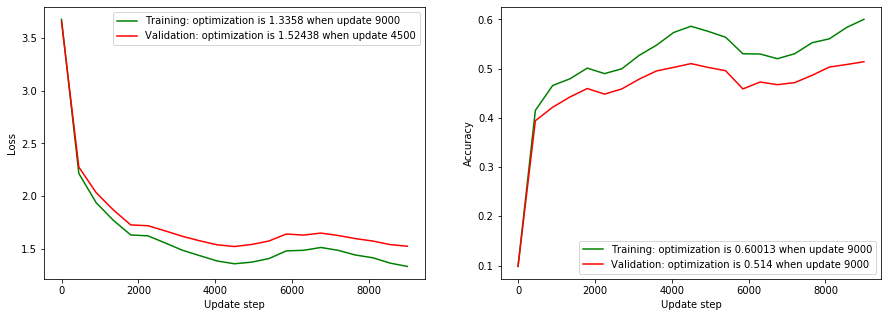

In [37]:
plot_training_performance(training_result)

### 2-layer network(with batch normalization)

In [33]:
layers_setting = [50]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True)

In update 450/9000 finishes epoch 1: loss=2.2820808229337635 and accuracy=0.39655555555555555 (training set) 
In update 900/9000 finishes epoch 2: loss=2.040995676592733 and accuracy=0.44655555555555554 (training set) 
In update 1350/9000 finishes epoch 3: loss=1.8465996293280753 and accuracy=0.4754888888888889 (training set) 
In update 1800/9000 finishes epoch 4: loss=1.7217816229554233 and accuracy=0.48377777777777775 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.671846388807102 and accuracy=0.48275555555555555 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.5879248437760412 and accuracy=0.5017555555555555 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.5486385488564234 and accuracy=0.5166222222222222 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.493890984390568 and accuracy=0.535 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.4406234802412803 and accuracy=0.5598444444444445 (training set) 
In update 4500/9000 fini

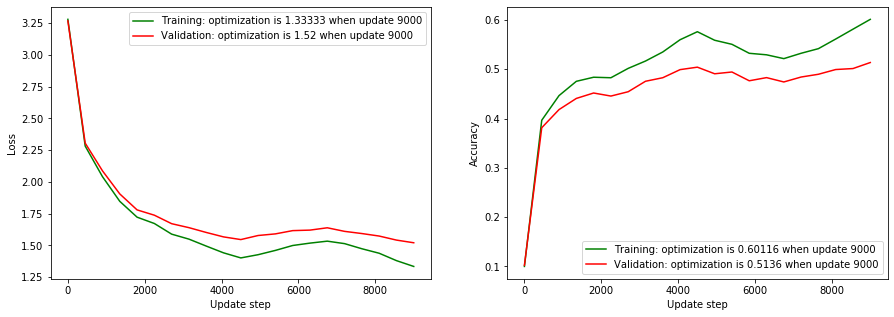

In [34]:
plot_training_performance(training_result)

### 3-layer network(without batch normalization)

In [51]:
layers_setting = [50, 50]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, 
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=False)

In update 450/9000 finishes epoch 1: loss=2.6804188247203333 and accuracy=0.4021111111111111 (training set) 
In update 900/9000 finishes epoch 2: loss=2.3248076829972426 and accuracy=0.4483333333333333 (training set) 
In update 1350/9000 finishes epoch 3: loss=2.008171569620477 and accuracy=0.47402222222222223 (training set) 
In update 1800/9000 finishes epoch 4: loss=1.7824493409311948 and accuracy=0.49977777777777777 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.7078210508861775 and accuracy=0.4865777777777778 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.5962851764833428 and accuracy=0.5070444444444444 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.5384162634973564 and accuracy=0.5275777777777778 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.4876395509713034 and accuracy=0.5437111111111111 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.4404109368190297 and accuracy=0.5641777777777778 (training set) 
In update 4

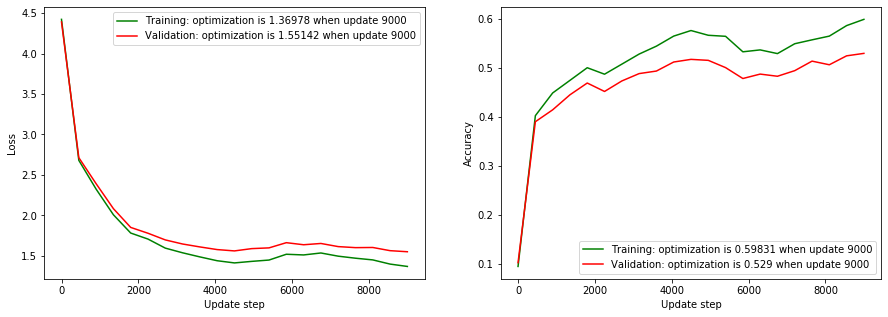

In [52]:
plot_training_performance(training_result, 'Figures/lab3/lab3_plot1.png')

### 3-layer network(with batch normalization)

In [53]:
layers_setting = [50, 50]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True)

In update 450/9000 finishes epoch 1: loss=2.74434098992613 and accuracy=0.392 (training set) 
In update 900/9000 finishes epoch 2: loss=2.3584524204852206 and accuracy=0.4535777777777778 (training set) 
In update 1350/9000 finishes epoch 3: loss=2.0300746972777817 and accuracy=0.4802 (training set) 
In update 1800/9000 finishes epoch 4: loss=1.7859743909886503 and accuracy=0.49866666666666665 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.6764239567606671 and accuracy=0.49333333333333335 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.5603721901111358 and accuracy=0.5149777777777778 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.4919747694537326 and accuracy=0.5338888888888889 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.4221604876490848 and accuracy=0.5587555555555556 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.3435855012256073 and accuracy=0.5843333333333334 (training set) 
In update 4500/9000 finishes epoch 10

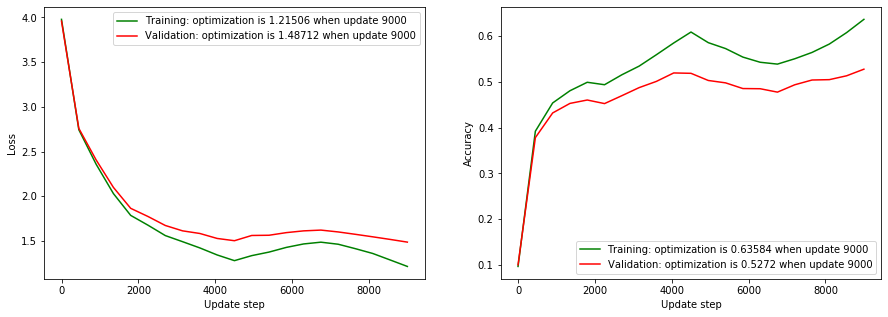

In [54]:
plot_training_performance(training_result, 'Figures/lab3/lab3_plot2.png')

### 9-layer network(without batch normalization)

In [55]:
layers_setting = [50,30,20,20,10,10,10,10]

W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, 
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=False)

In update 450/9000 finishes epoch 1: loss=3.774147448365838 and accuracy=0.19957777777777777 (training set) 
In update 900/9000 finishes epoch 2: loss=3.103214975221397 and accuracy=0.29264444444444443 (training set) 
In update 1350/9000 finishes epoch 3: loss=2.550235849461096 and accuracy=0.3736 (training set) 
In update 1800/9000 finishes epoch 4: loss=2.223233627926368 and accuracy=0.38337777777777776 (training set) 
In update 2250/9000 finishes epoch 5: loss=2.089928581805571 and accuracy=0.38526666666666665 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.8911670269406675 and accuracy=0.43424444444444443 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.8387583274089208 and accuracy=0.4494444444444444 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.7715586596860513 and accuracy=0.46742222222222224 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.722468675991998 and accuracy=0.4885555555555556 (training set) 
In update 4500/9000 fini

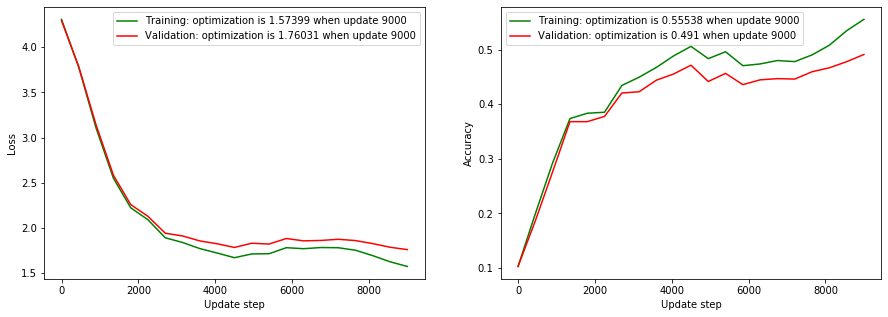

In [56]:
plot_training_performance(training_result, 'Figures/lab3/lab3_plot3.png')

### 9-layer network(with batch normalization)

In [57]:
layers_setting = [50,30,20,20,10,10,10,10]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True)

In update 450/9000 finishes epoch 1: loss=3.724297761049068 and accuracy=0.20042222222222222 (training set) 
In update 900/9000 finishes epoch 2: loss=3.115014885878393 and accuracy=0.3265777777777778 (training set) 
In update 1350/9000 finishes epoch 3: loss=2.546168994692135 and accuracy=0.3845777777777778 (training set) 
In update 1800/9000 finishes epoch 4: loss=2.1744688638575007 and accuracy=0.4014888888888889 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.9278252158998386 and accuracy=0.4184888888888889 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.7775921271207875 and accuracy=0.44835555555555556 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.6870629781091562 and accuracy=0.466 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.6298956416580128 and accuracy=0.4839555555555556 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.5150041211558485 and accuracy=0.5242666666666667 (training set) 
In update 4500/9000 finish

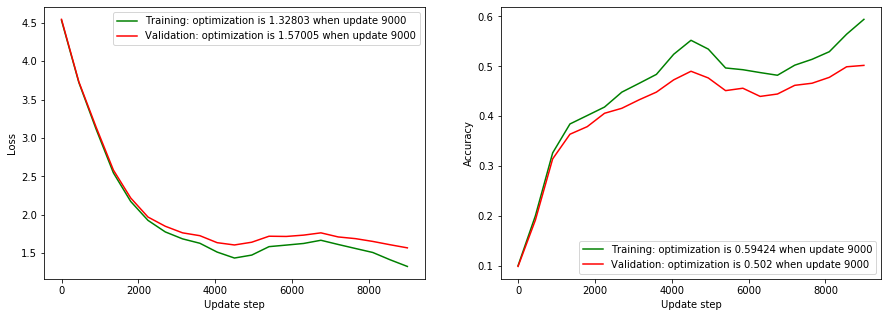

In [58]:
plot_training_performance(training_result, 'Figures/lab3/lab3_plot4.png')

### Coarse-to-fine random search to set $\lambda$

In [46]:
def lambda_search(lambdas, repeat, hidden_dimension, X, Y, y, parameters, X_val=None,
                  Y_val=None, y_val=None):
    
    lambda_result = {'lambdas': [], 'loss_train_mean': [], 'acc_train_mean': [], 'loss_train_std': [],
                       'acc_train_std': []}
    if X_val is not None:
        lambda_result['loss_val_mean'] = []
        lambda_result['acc_val_mean'] = []
        lambda_result['loss_val_std'] = []
        lambda_result['acc_val_std'] = []

    # Search the different lambdas in loop
    for lambda_ in lambdas:

        # Create a dictionary to store the performance train_result of this particular lambda by randomizations
        repeat_exp = {'loss_train': [], 'acc_train': []}
        if X_val is not None:
            repeat_exp['loss_val'] = []
            repeat_exp['acc_val'] = []

        # Repeat experiments
        for r in range(repeat):

            #W1, b1, W2, b2 = initialization(X.shape[0], hidden_dimension, Y.shape[0], r * 5)
            #W1, b1, W2, b2, train_result = train_network(X, Y, y, parameters, W1, W2, b1, b2, X_val=X_val,
            #                                        Y_val=Y_val, y_val=y_val, lambda_=lambda_, report_process=False)
            
            W, b, gamma, beta = initialization(X.shape[0], hidden_dimension, Y.shape[0], r * 5)

            # Train the network
            W, b, gamma, beta, mean_avg, var_avg, train_result = train_network(X, Y, y, parameters, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True, report_process=False)

            repeat_exp['loss_train'].append(train_result['loss_train'][-1])
            repeat_exp['acc_train'].append(train_result['acc_train'][-1])
            if X_val is not None:
                repeat_exp['loss_val'].append(train_result['loss_val'][-1])
                repeat_exp['acc_val'].append(train_result['acc_val'][-1])

        lambda_result['lambdas'].append(lambda_)
        lambda_result['loss_train_mean'].append(np.mean(repeat_exp['loss_train']))
        lambda_result['acc_train_mean'].append(np.mean(repeat_exp['acc_train']))
        lambda_result['loss_train_std'].append(np.std(repeat_exp['loss_train']))
        lambda_result['acc_train_std'].append(np.std(repeat_exp['acc_train']))
        if X_val is not None:
            lambda_result['loss_val_mean'].append(np.mean(repeat_exp['loss_val']))
            lambda_result['acc_val_mean'].append(np.mean(repeat_exp['acc_val']))
            lambda_result['loss_val_std'].append(np.std(repeat_exp['loss_val']))
            lambda_result['acc_val_std'].append(np.std(repeat_exp['acc_val']))
        print("Lambda: ", lambda_, " has been searched.")
    return lambda_result

In [47]:
def plot_lambdas_performance(lambda_result, log_scale = True, save_path = None):
    
    _, plots = plt.subplots(1, 2, figsize=(15, 5))
    
    for plot_type, ax in zip(['loss', 'acc'], plots.flatten()):
        
        # Plot training curve
        best_epoch_train = np.argmin(lambda_result[plot_type + '_train_mean']) if plot_type == 'loss' else np.argmax(
            lambda_result[plot_type + '_train_mean'])
        optimal_value_train = np.round(lambda_result[plot_type + '_train_mean'][best_epoch_train], 3)

        label = 'Training: ' + 'optimization is ' + str(optimal_value_train) + ' when lambda is ' + str(
            lambda_result['lambdas'][best_epoch_train])
        
        x = np.log(lambda_result['lambdas']) if log_scale else lambda_result['lambdas']
        y = lambda_result[plot_type+'_train_mean']
        
        ax.plot(x, y, color='g', label=label)
        
        # Plot validation curve
        best_epoch_val = np.argmin(lambda_result[plot_type + '_val_mean']) if plot_type == 'loss' else np.argmax(
            lambda_result[plot_type + '_val_mean'])
        optimal_value_val = np.round(lambda_result[plot_type + '_val_mean'][best_epoch_val], 3)

        label = 'Validation: ' + 'optimization is ' + str(optimal_value_val) + ' when lambda is ' + str(
            lambda_result['lambdas'][best_epoch_val])
        
        x = np.log(lambda_result['lambdas']) if log_scale else lambda_result['lambdas']
        y = lambda_result[plot_type+'_val_mean']
        ax.plot(x, y, color='r', label=label)

        
        ax.set_xlabel("Log Lambdas" if log_scale else "Lambdas")
        ax.set_ylabel('Accuracy' if plot_type == 'acc' else 'Loss')
        ax.legend()
        if save_path is not None:
            plt.savefig(save_path)

In [29]:
X1,Y1,y1 = LoadBatch('data_batch_1')
X2,Y2,y2 = LoadBatch('data_batch_2')
X3,Y3,y3 = LoadBatch('data_batch_3')
X4,Y4,y4 = LoadBatch('data_batch_4')
X5,Y5,y5 = LoadBatch('data_batch_5')
Xtest, Ytest, ytest = LoadBatch('test_batch')

#### Coarse random search

In [43]:
np.random.seed(30)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
coarse_lambdas = list(10**l)
coarse_lambdas.sort()
print(coarse_lambdas)

[4.5144298035108406e-05, 8.714281448909179e-05, 0.00024358321678948287, 0.00033342177450911654, 0.00042340931328290745, 0.0022017959781029353, 0.0037720213678308903, 0.004489434310567925, 0.07086491241497783, 0.09268382940512102]


In [48]:
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Search for lambda
lambda_result = lambda_search(coarse_lambdas, repeat=5, hidden_dimension=[50, 50], X=X_train, 
                Y=Y_train, y=y_train, parameters=parameters, X_val=X_val,
                Y_val=Y_val, y_val=y_val)

Lambda:  4.5144298035108406e-05  has been searched.
Lambda:  8.714281448909179e-05  has been searched.
Lambda:  0.00024358321678948287  has been searched.
Lambda:  0.00033342177450911654  has been searched.
Lambda:  0.00042340931328290745  has been searched.
Lambda:  0.0022017959781029353  has been searched.
Lambda:  0.0037720213678308903  has been searched.
Lambda:  0.004489434310567925  has been searched.
Lambda:  0.07086491241497783  has been searched.
Lambda:  0.09268382940512102  has been searched.


In [50]:
acc_list = lambda_result['acc_val_mean']
max_3_index = list(map(acc_list.index, heapq.nlargest(3, acc_list)))
max_3_index.sort()
for index in max_3_index:
    print(lambda_result['lambdas'][index], lambda_result['acc_val_mean'][index])

0.0022017959781029353 0.5200400000000001
0.0037720213678308903 0.52576
0.004489434310567925 0.52608


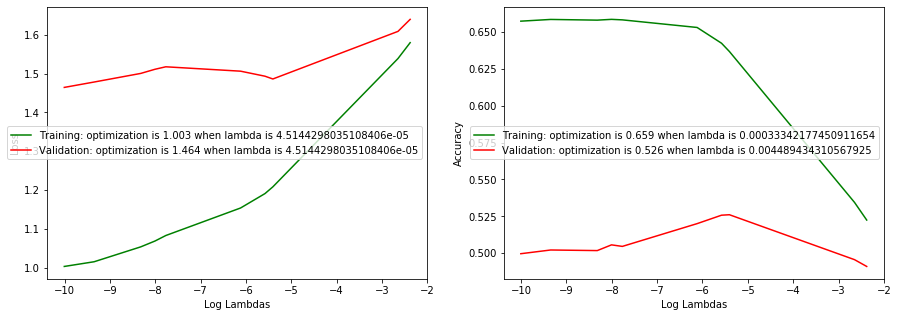

In [49]:
plot_lambdas_performance(lambda_result)

#### Fine random search

In [59]:
fine_lambdas = np.arange(0.001, 0.006, 0.001)
fine_lambdas

array([0.001, 0.002, 0.003, 0.004, 0.005])

In [60]:
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':3}

# Search for lambda
lambda_result = lambda_search(fine_lambdas, repeat=5, hidden_dimension=[50, 50], X=X_train, 
                Y=Y_train, y=y_train, parameters=parameters, X_val=X_val,
                Y_val=Y_val, y_val=y_val)

Lambda:  0.001  has been searched.
Lambda:  0.002  has been searched.
Lambda:  0.003  has been searched.
Lambda:  0.004  has been searched.
Lambda:  0.005  has been searched.


In [61]:
acc_list = lambda_result['acc_val_mean']
max_3_index = list(map(acc_list.index, heapq.nlargest(3, acc_list)))
max_3_index.sort()
for index in max_3_index:
    print(lambda_result['lambdas'][index], lambda_result['acc_val_mean'][index])

0.003 0.52964
0.004 0.53004
0.005 0.5341600000000001


## Train the network by best $\lambda$ setting

In [62]:
layers_setting = [50, 50]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005

parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True)

In update 450/9000 finishes epoch 1: loss=2.74434098992613 and accuracy=0.392 (training set) 
In update 900/9000 finishes epoch 2: loss=2.3584524204852206 and accuracy=0.4535777777777778 (training set) 
In update 1350/9000 finishes epoch 3: loss=2.0300746972777817 and accuracy=0.4802 (training set) 
In update 1800/9000 finishes epoch 4: loss=1.7859743909886503 and accuracy=0.49866666666666665 (training set) 
In update 2250/9000 finishes epoch 5: loss=1.6764239567606671 and accuracy=0.49333333333333335 (training set) 
In update 2700/9000 finishes epoch 6: loss=1.5603721901111358 and accuracy=0.5149777777777778 (training set) 
In update 3150/9000 finishes epoch 7: loss=1.4919747694537326 and accuracy=0.5338888888888889 (training set) 
In update 3600/9000 finishes epoch 8: loss=1.4221604876490848 and accuracy=0.5587555555555556 (training set) 
In update 4050/9000 finishes epoch 9: loss=1.3435855012256073 and accuracy=0.5843333333333334 (training set) 
In update 4500/9000 finishes epoch 10

In [64]:
accuracy = ComputeAccuracy_BN(Xtest, ytest, W, b, gamma, beta, mean_avg, var_avg)
print(accuracy)

0.5269


## Sensitivity to initialization

In [21]:
def initialization_normal(input_dimension, hidden_dimensions, output_dimension, sig, seed=233): 
    
    k = len(hidden_dimensions)+1
    
    W, b, gamma, beta = [None]*k, [None]*k, [None]*(k-1), [None]*(k-1)
    net_dimensions = [input_dimension]+hidden_dimensions+[output_dimension]
    
    # Initialization
    np.random.seed(seed)
    for layer in range(k):
        
        inputs = net_dimensions[layer]
        outputs = net_dimensions[layer+1]
        
        W[layer] = np.random.normal(size=(outputs, inputs), loc=0, scale=sig)
        b[layer] = np.zeros((outputs, 1))
        if layer<(k-1):
            gamma[layer] = np.ones((outputs, 1))
            beta[layer] = np.zeros((outputs, 1))
        
    return W, b, gamma, beta

In [22]:
layers_setting = [50, 50]
W, b, gamma, beta = initialization(X_train.shape[0], layers_setting, Y_train.shape[0])
lambda_ = 0.005
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}
sigmas = [1e-1,1e-3,1e-4]
sigmas_result = []
train_results = []

for s in sigmas:
    W, b, gamma, beta = initialization_normal(X_train.shape[0], layers_setting, Y_train.shape[0], s)
    for BN in [False, True]:
        if BN==False:
            W, b, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, 
            X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=False, report_process=False)
            acc = ComputeAccuracy(Xtest, ytest, W, b)

        else:
            W, b, gamma, beta, mean_avg, var_avg, training_result = train_network(X_train, Y_train, y_train, parameters, lambda_, W, b, gamma=gamma, beta=beta,
            X_val=X_val, Y_val=Y_val, y_val=y_val, batch_normalization=True, report_process=False)
            acc = ComputeAccuracy_BN(Xtest, ytest, W, b, gamma, beta, mean_avg, var_avg)
            
        sigmas_result.append([s, BN, acc])
        train_results.append(training_result)

In [69]:
sigmas_result

[[0.1, False, 0.5182],
 [0.1, True, 0.5226],
 [0.001, False, 0.4528],
 [0.001, True, 0.5265],
 [0.0001, False, 0.1],
 [0.0001, True, 0.5259]]

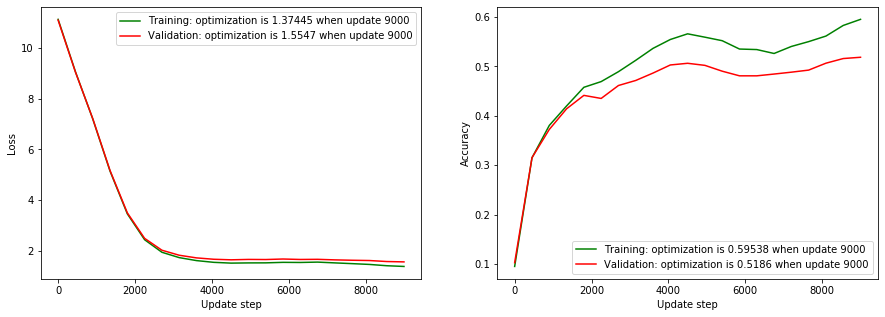

In [73]:
plot_training_performance(train_results[0])

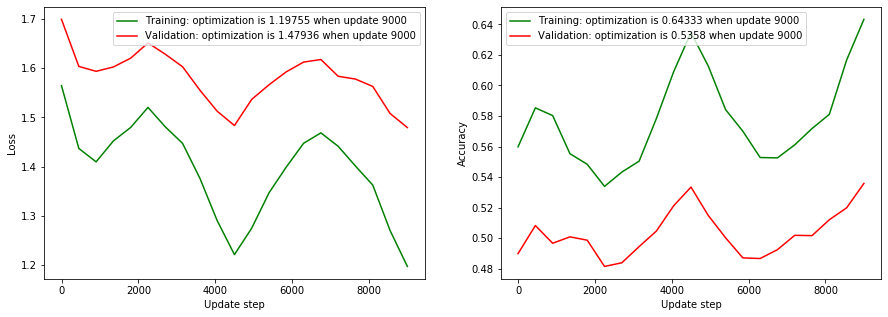

In [74]:
plot_training_performance(train_results[1])

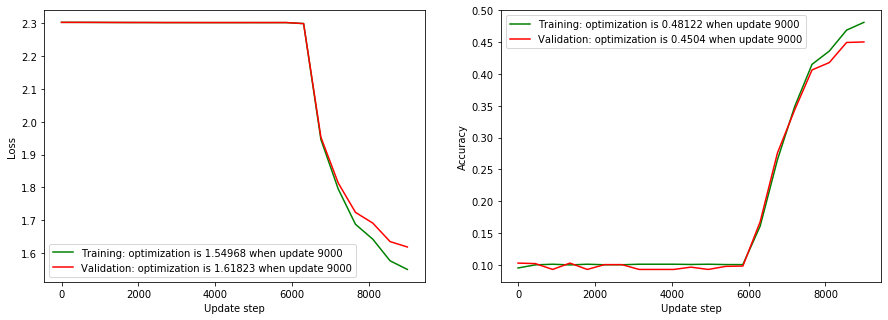

In [25]:
plot_training_performance(train_results[2])

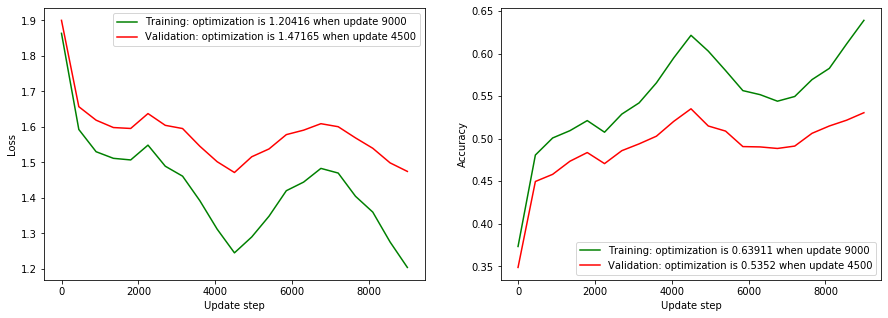

In [26]:
plot_training_performance(train_results[3])

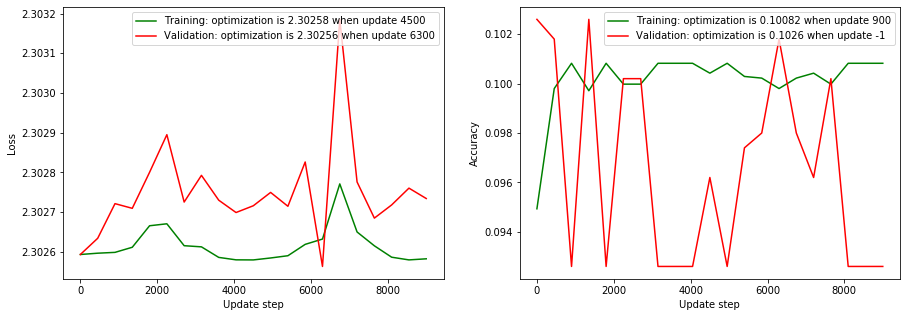

In [27]:
plot_training_performance(train_results[4])

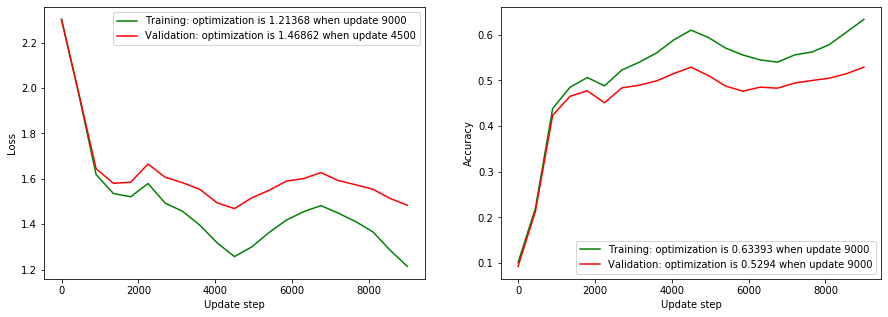

In [28]:
plot_training_performance(train_results[5])